# Transfer learning Using ImageNet with TensorFlow Hub for MNIST Fashion

This Jupyter notebook applies transferlearning from ImageNet to MNIST fashion by 
1. Using TensorFlow Hub with `tf.keras`.
1. Classification with TensorFlow Hub.
1. Simple transfer learning

In [2]:
# Initial Setup
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras

#### Download and prepare the MNIST fashion data

In [3]:
# Load MNIST data 
fashion_mnist = keras.datasets.fashion_mnist
(MNISTtrain_images, MNISTtrain_labels), (MNISTtest_images, MNISTtest_labels) = fashion_mnist.load_data()
print("shape of the original training set images is = ",MNISTtrain_images.shape)
print("shape of the original training set labels is = ",MNISTtrain_labels.shape)
print("shape of the original testing set images is = ",MNISTtest_images.shape)
print("shape of the original testing set label is = ",MNISTtest_labels.shape)

shape of the original training set images is =  (60000, 28, 28)
shape of the original training set labels is =  (60000,)
shape of the original testing set images is =  (10000, 28, 28)
shape of the original testing set label is =  (10000,)


In [4]:
# To resize the image from MNIST size to MobileNet and remove the channels
def convert_to_color(images, size=(224,224)):
    images_2 = np.stack((images,)*3, axis=-1)
    images_3 = tf.image.resize(
        images_2, 
        size, 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    images_3
    images_3 = tf.cast(images_3, tf.float16) # MODIFIED

    return images_3

In [5]:
# Convert MNIST image size ot  MobileNet image size and scaling to a value between 0 and 1

m = 10000  # Small chunks are used instead of whole trainign set because of memory limits
n = 60000//m

train_images = convert_to_color(MNISTtrain_images[:m] / 255.0)

for i in range(1,n): 
    train_im0 = convert_to_color(MNISTtrain_images[m*i:m*(i+1)]/225.0)
    train_images =  np.concatenate((train_images, train_im0), axis=0)
    print(100.0*int((i+1)/n),"% out of the training set is converted")   
    
test_images0  = MNISTtest_images  / 255.0
test_images   = convert_to_color(test_images0)  

print("shape of the training set images is = ",train_images.shape)
print("shape of the testing set images is = ",test_images.shape)

16.666666666666668 % out of the training set is converted
25.0 % out of the training set is converted
33.333333333333336 % out of the training set is converted
41.666666666666664 % out of the training set is converted
50.0 % out of the training set is converted
58.333333333333336 % out of the training set is converted
66.66666666666667 % out of the training set is converted
75.0 % out of the training set is converted
83.33333333333333 % out of the training set is converted
91.66666666666667 % out of the training set is converted
100.0 % out of the training set is converted
shape of the training set images is =  (60000, 224, 224, 3)
shape of the testing set images is =  (10000, 224, 224, 3)


In [6]:
# Generate one hot value for the labels
def convert_to_one_hot(labels):
    rows = np.arange(labels.size)
    one_hot = np.zeros((labels.size, labels.max()+1))
    one_hot[rows, labels] = 1
    return one_hot

In [7]:
# Convert MNIST labels to onehot
train_labels = convert_to_one_hot(MNISTtrain_labels)
test_labels = convert_to_one_hot(MNISTtest_labels)
test_labels.shape

(10000, 10)

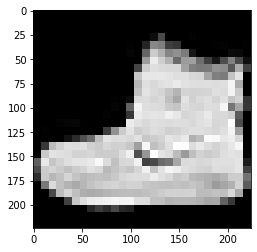

In [8]:
im = train_images[0].astype('float')
plt.figure()
plt.imshow(im)
plt.grid(False)

plt.show()

In [9]:
#Add the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_classes = len(class_names)  # MODIFIED

#### Download the headless model

For transfer learning, use TensorFlow Hub to distribute models without the top classification layer. 

Any of the [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) models from tfhub.dev works here

In [10]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [11]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [12]:
# Freeze the training for the extracted layers. 
feature_extractor_layer.trainable = False

#### Attach a classification head

In [13]:
# Wrapping the hub layer: Add a new classification layer  a `tf.keras.Sequential` model
# Attach a classification head
# Attach a classification head
model = tf.keras.Sequential([feature_extractor_layer])
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['acc'])

In [81]:
tf.config.experimental_run_functions_eagerly(False)

batch_stats_callback = CollectBatchStats()

# In the recents Keras updates fit_generator is replaced with fit
model.fit(train_images, train_labels, batch_size=64,callbacks = [batch_stats_callback],
          steps_per_epoch=50, shuffle=True, epochs = 20, use_multiprocessing=True)

Train on 60000 samples
Epoch 1/20
 3200/60000 [>.............................] - ETA: 13:00 - loss: 1.6332 - acc: 0.8594

In [82]:
#Predictions for the first 30 images
#Actual IDs
#train_images.astype('float')
label_id = np.argmax(test_labels, axis=-1)

#Predictions
predicted = model.predict(test_images[:30])
predicted_id = np.argmax(predicted, axis=-1)
predicted_label_batch =  list(map(lambda i: class_names[i], predicted_id))

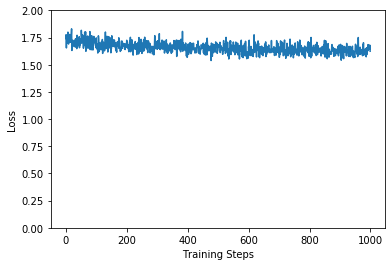

In [83]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

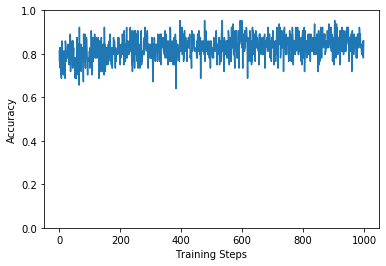

In [84]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

In [85]:
# convert the format
testshow = tf.cast(test_images[:30],'float64')

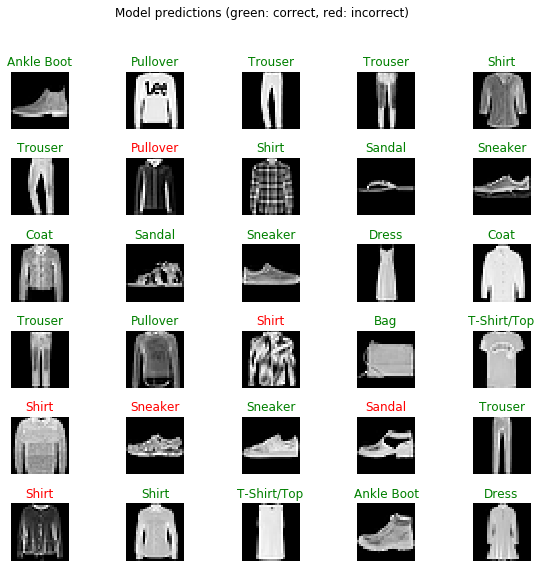

In [86]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(testshow[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [87]:
# Save the model
export_path = 'MyModel'
model.save(export_path, save_format='tf')

INFO:tensorflow:Assets written to: MyModel\assets


INFO:tensorflow:Assets written to: MyModel\assets


In [88]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(test_images)
reloaded_result_batch = reloaded.predict(test_images)
abs(reloaded_result_batch - result_batch).max()

0.0